✅ Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.makedirs("visuals", exist_ok=True)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

✅ Step 2: Load TrendCart Dataset

In [2]:
df = pd.read_csv("trendcart_realistic_reviews.csv")
df = df.dropna(subset=["ReviewText", "Sentiment"])

In [3]:
df.head()

,CustomerID,ProductCategory,Location,PaymentMethod,DeliveryRating,ReviewText,Sentiment,OrderAmount,OrderDate,LastOrderDate,ReturnRequested,Churned
0,CUST1000,Books,HSR Layout,COD,3,"Decent books, but delivery took longer than ex...",Neutral,2532.45,2025-02-19,2025-02-19,No,Yes
1,CUST1001,Home Decor,HSR Layout,UPI,5,"The home decor is okay, does the job but nothi...",Neutral,1248.53,2024-12-22,2024-12-22,No,Yes
2,CUST1002,Fashion,Indiranagar,Credit Card,1,The fashion broke within a few days. Not recom...,Negative,1402.43,2025-04-21,2025-04-21,No,No
3,CUST1003,Grocery,BTM Layout,Credit Card,3,Great value for money. This grocery is just wh...,Positive,553.96,2025-02-06,2025-02-06,No,Yes
4,CUST1004,Home Decor,HSR Layout,COD,3,Very satisfied with the home decor. Will defin...,Positive,3132.26,2024-12-07,2024-12-07,No,Yes


✅ Step 3: Clean Text

In [4]:
stopwords = set([
    'the','a','an','in','on','and','is','it','to','of','for','with','this','that',
    'be','was','as','at','by','from','or','are','has','have','but','not','we','they',
    'you','i','he','she','my','our','just','very','will','can','could','should'
])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stopwords and word.isalpha()]
    return ' '.join(words)

df['CleanedReview'] = df['ReviewText'].apply(clean_text)

✅ Step 4: Visualize Sentiment Distribution

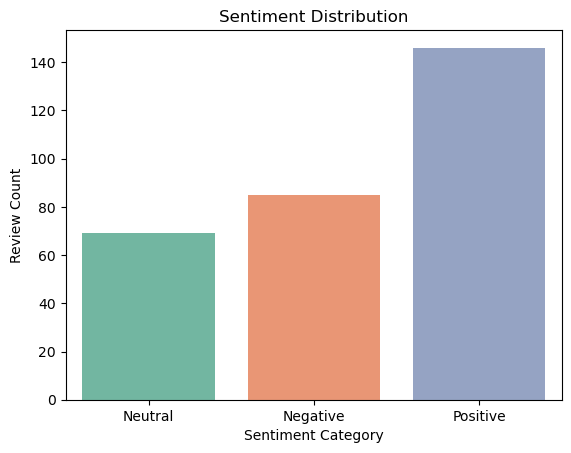

In [5]:
sns.countplot(data=df, x='Sentiment', palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Category")
plt.ylabel("Review Count")
plt.show()

✅ Step 5: Encode Sentiment + Vectorize Text

In [6]:
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['SentimentLabel'] = df['Sentiment'].map(sentiment_map)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['CleanedReview']).toarray()
y = df['SentimentLabel']

✅ Step 6: Top Words by Frequency

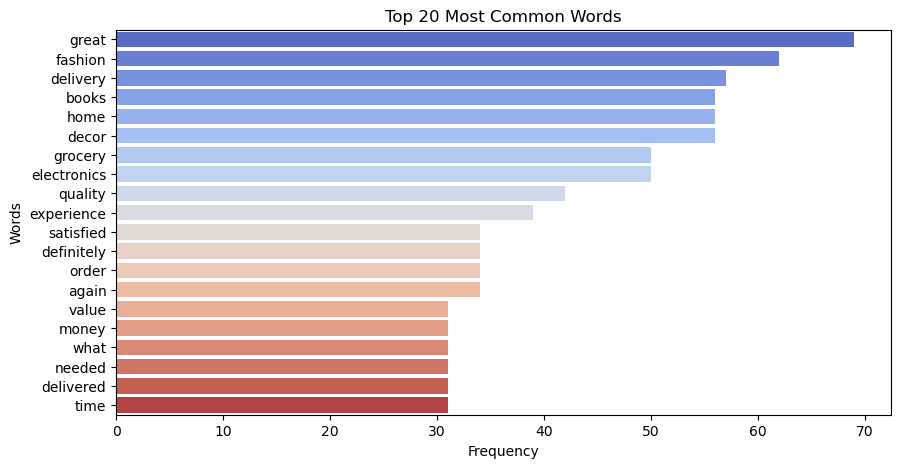

In [7]:
from collections import Counter
all_words = ' '.join(df['CleanedReview']).split()
common_words = Counter(all_words).most_common(20)

words, freqs = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(freqs), y=list(words), palette='coolwarm')
plt.title("Top 20 Most Common Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

📌 Step 6B: Generate WordClouds by Sentiment

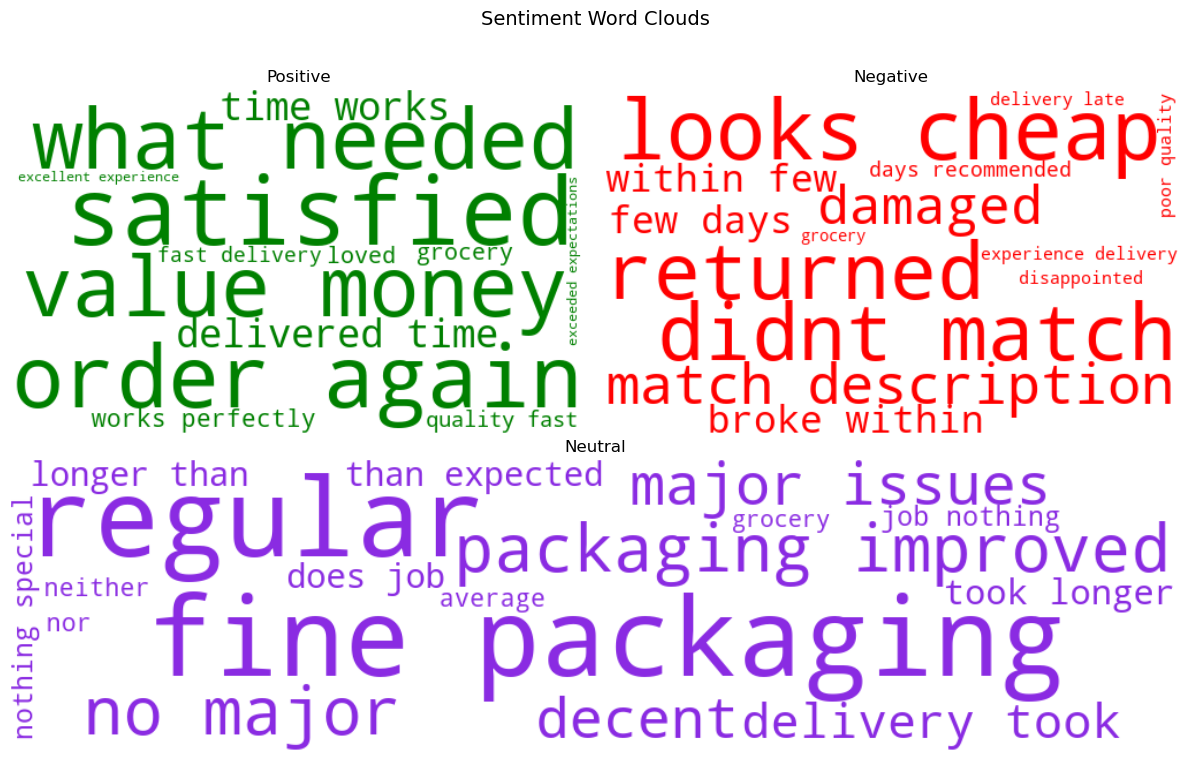

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.gridspec as gridspec

# Stopwords
custom_stopwords = set([
    'the','a','an','in','on','and','is','it','to','of','for','with','this','that',
    'be','was','as','at','by','from','or','are','has','have','but','not','we','they',
    'you','i','he','she','my','our','just','very','will','can','could','should',
    'definitely','really','great','nice','ok','okay','good','bad','best','worst',
    'amazing','awesome','terrible','love','hate','liked','disliked','product','item',
    'electronics','worth','home','decor','books','fashion','price'
])

# Texts
positive_text = ' '.join(df[df['Sentiment'] == 'Positive']['CleanedReview'])
negative_text = ' '.join(df[df['Sentiment'] == 'Negative']['CleanedReview'])
neutral_text  = ' '.join(df[df['Sentiment'] == 'Neutral']['CleanedReview'])

# Color functions
def green_color_func(word, **kwargs): return "green"
def red_color_func(word, **kwargs): return "red"
def violet_color_func(word, **kwargs): return "#8A2BE2"

# Generate WordClouds
wc_pos = WordCloud(width=500, height=300, background_color='white', stopwords=custom_stopwords).generate(positive_text)
wc_neg = WordCloud(width=500, height=300, background_color='white', stopwords=custom_stopwords).generate(negative_text)
wc_neu = WordCloud(width=1000, height=250, background_color='white', stopwords=custom_stopwords).generate(neutral_text)

# Custom grid layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top left: Positive
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(wc_pos.recolor(color_func=green_color_func), interpolation='bilinear')
ax1.set_title("Positive", fontsize=12)
ax1.axis('off')

# Top right: Negative
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(wc_neg.recolor(color_func=red_color_func), interpolation='bilinear')
ax2.set_title("Negative", fontsize=12)
ax2.axis('off')

# Bottom center: Neutral spanning both columns
ax3 = fig.add_subplot(gs[1, :])
ax3.imshow(wc_neu.recolor(color_func=violet_color_func), interpolation='bilinear')
ax3.set_title("Neutral", fontsize=12)
ax3.axis('off')

plt.suptitle("Sentiment Word Clouds", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("visuals/sentiment_wordclouds.png")
plt.show()

✅ Step 7: Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

✅ Step 8: Train Models

In [10]:
# Logistic Regression
lr = LogisticRegression(max_iter=300)
grid_lr = GridSearchCV(lr, {'C': [0.1, 1, 10]}, cv=3)
grid_lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

✅ Step 9: Evaluate Models + Visualize Confusion

Logistic Regression Performance:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        17
           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        29

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



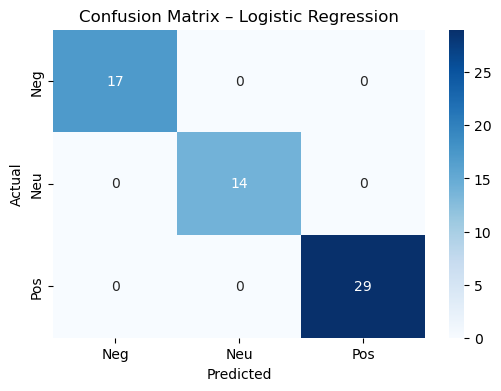

In [11]:
y_pred = grid_lr.predict(X_test)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

✅ Step 10: TF-IDF Feature Heatmap (Optional Insight)

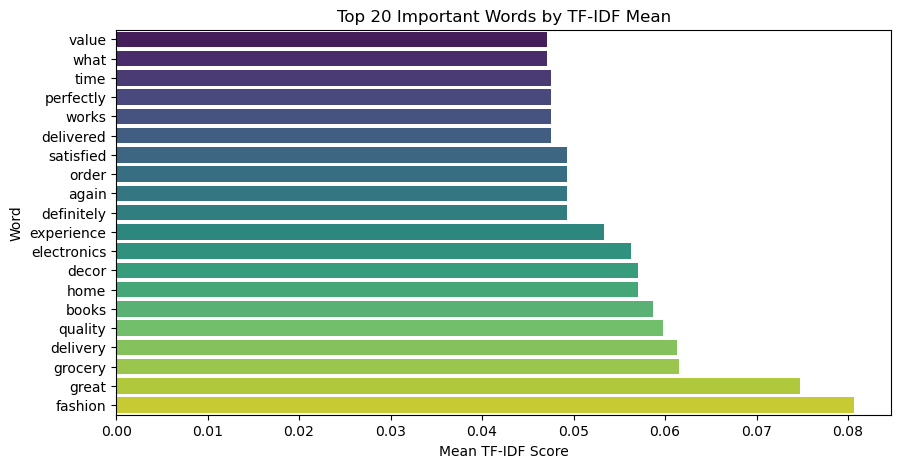

In [12]:
feature_names = vectorizer.get_feature_names_out()
importance = np.mean(X_train, axis=0)

top_n = 20
indices = np.argsort(importance)[-top_n:]

plt.figure(figsize=(10,5))
sns.barplot(x=importance[indices], y=np.array(feature_names)[indices], palette='viridis')
plt.title("Top 20 Important Words by TF-IDF Mean")
plt.xlabel("Mean TF-IDF Score")
plt.ylabel("Word")
plt.show()

✅ Step 11: Save Final Output with Prediction

In [13]:
df['PredictedSentiment'] = grid_lr.predict(X)
df.to_csv("trendcart_sentiment_model_output.csv", index=False)
print("✅ File saved as: trendcart_sentiment_model_output.csv")

✅ File saved as: trendcart_sentiment_model_output.csv


✅ Step 12: Sentiment Trend Over Time (Line Chart)


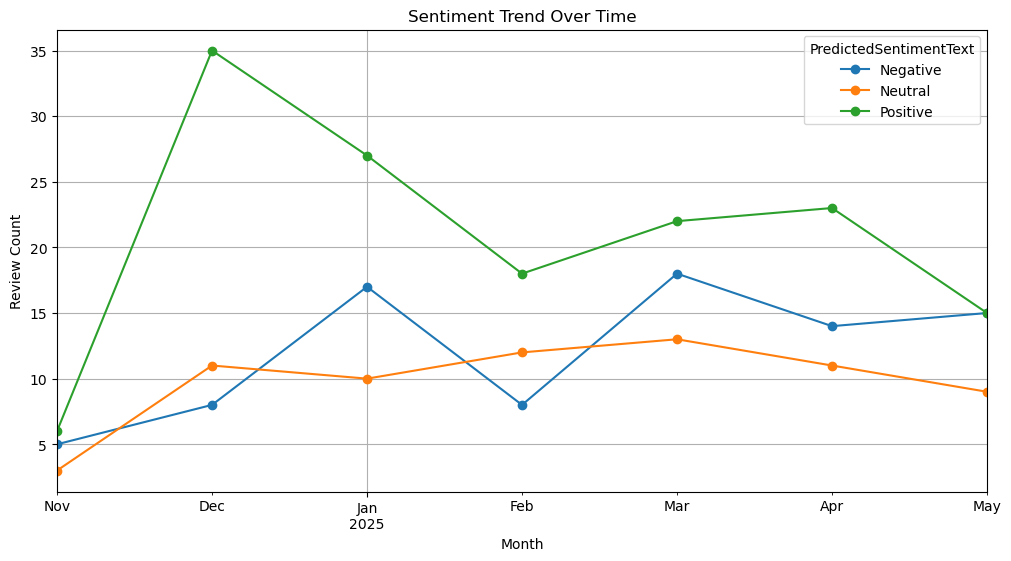

In [14]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Map numeric sentiment to text
sentiment_map_rev = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
df['PredictedSentimentText'] = df['PredictedSentiment'].map(sentiment_map_rev)

# Group by Month + Sentiment
sentiment_trend = df.groupby([df['OrderDate'].dt.to_period("M"), 'PredictedSentimentText']).size().unstack().fillna(0)
sentiment_trend.index = sentiment_trend.index.to_timestamp()

# Plot
sentiment_trend.plot(figsize=(12, 6), marker='o')
plt.title("Sentiment Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.grid(True)
plt.savefig("visuals/sentiment_trend.png")
plt.show()

✅ Step 13: Sentiment by Product Category (Bar Chart)


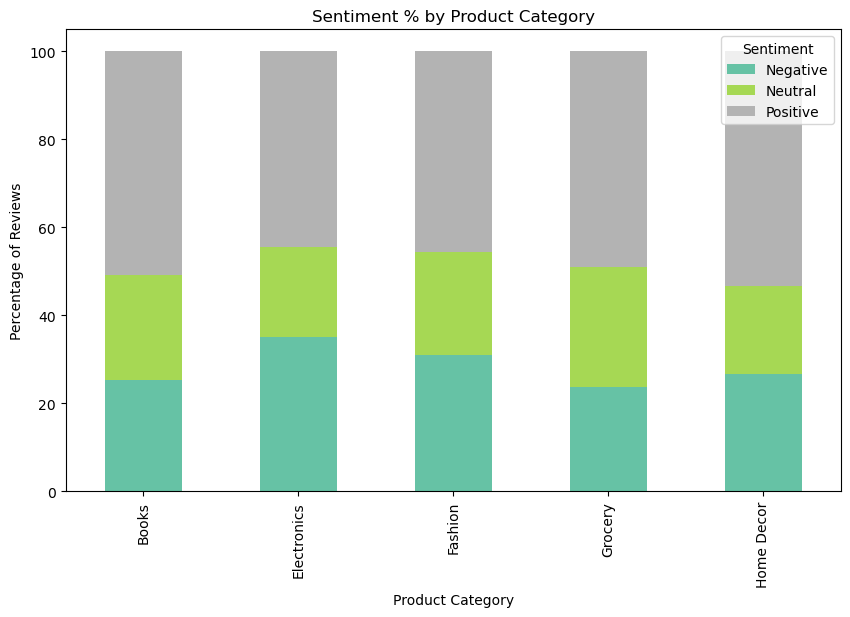

In [15]:
category_sentiment = df.groupby(['ProductCategory', 'PredictedSentimentText']).size().unstack().fillna(0)

# Optional: Normalize to percentage
category_sentiment_pct = category_sentiment.div(category_sentiment.sum(axis=1), axis=0) * 100

# Plot
category_sentiment_pct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title("Sentiment % by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Percentage of Reviews")
plt.legend(title="Sentiment")
plt.savefig("visuals/sentiment_by_category.png")
plt.show()

✅ Step 14: Top Complaint Keywords (Negative Reviews)


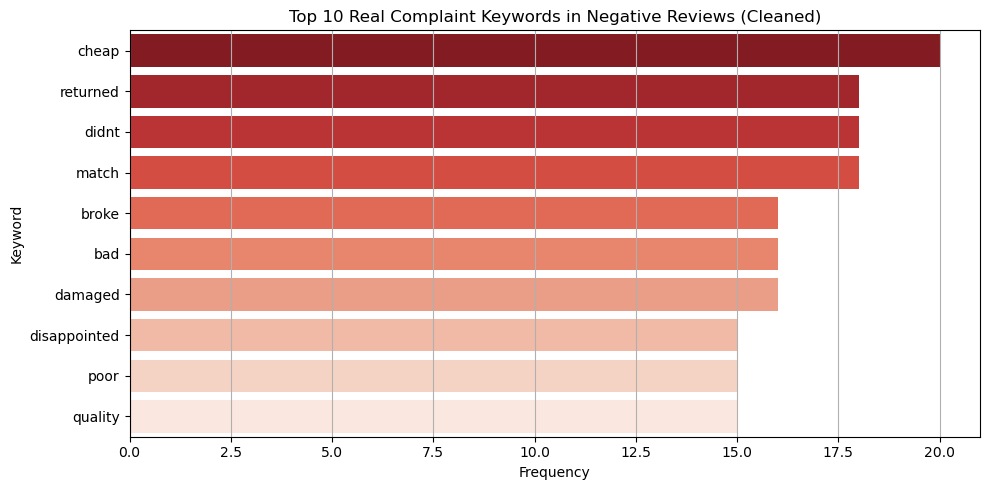

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Updated stopwords with generic + category words
custom_stopwords = set([
    'the','a','an','in','on','and','is','it','to','of','for','with','this','that',
    'be','was','as','at','by','from','or','are','has','have','but','not','we','they',
    'you','i','he','she','my','our','just','very','will','can','could','should',
    'definitely','really','great','nice','ok','okay','good','best',
    'amazing','awesome','love','liked','product','item',
    'within','few','days','recommended','home','decor','experience','delivery','late',
    'useful','thing','way','still','enough','overall','something','fine','looks',
    'work','service','customer','worth','price','electronics','description',
    'fashion','books','grocery'
])

# Process only negative reviews
negative_words = ' '.join(df[df['PredictedSentimentText'] == 'Negative']['CleanedReview']).split()
filtered_words = [word for word in negative_words if word not in custom_stopwords and len(word) > 2]

# Get top complaints
common_neg = Counter(filtered_words).most_common(20)
words, counts = zip(*common_neg)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(words), palette="Reds_r")
plt.title("Top 10 Real Complaint Keywords in Negative Reviews (Cleaned)")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.grid(axis='x')
plt.tight_layout()
plt.savefig("visuals/top_complaints.png")
plt.show()

✅ Step 15: Export Tableau Summary CSV

In [17]:
summary = df.groupby(['ProductCategory', 'PredictedSentimentText']).size().unstack().fillna(0)
summary['Total'] = summary.sum(axis=1)
summary['% Positive'] = round((summary['Positive'] / summary['Total']) * 100, 2)
summary['% Negative'] = round((summary['Negative'] / summary['Total']) * 100, 2)
summary.reset_index(inplace=True)

summary.to_csv("sentiment_summary_for_tableau.csv", index=False)
print("✅ Exported summary for Tableau: sentiment_summary_for_tableau.csv")

✅ Exported summary for Tableau: sentiment_summary_for_tableau.csv
